# ** Import Libraries **

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import accuracy_score, confusion_matrix
import os
from pathlib import Path
from tqdm.auto import tqdm
import random
from typing import Dict,List
import warnings
warnings.filterwarnings("ignore")

# ** Load Data and EDA **

In [4]:
# Tổng số hình ảnh
IMAGE_PATH = Path("D:/garbage_classification/")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*.jpg"))

print(f"Tổng số hình ảnh = {len(IMAGE_PATH_LIST)}")

Tổng số hình ảnh = 10163


In [5]:
# Tổng số hình ảnh cho mỗi lớp
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)

print("**" * 30)
print(" " * 17, "Tổng số hình ảnh cho mỗi lớp")
print("**" * 30)
for c in classes:
    imgs_class = len(list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg")))
    print(f"* {c} => {imgs_class} images")

************************************************************
                  Tổng số hình ảnh cho mỗi lớp
************************************************************
* battery => 945 images
* biological => 985 images
* brown-glass => 607 images
* cardboard => 891 images
* clothes => 1000 images
* green-glass => 629 images
* metal => 769 images
* paper => 1000 images
* plastic => 865 images
* shoes => 1000 images
* trash => 697 images
* white-glass => 775 images


In [6]:
for c in classes:
    class_path = os.path.join(IMAGE_PATH, c)
    image_list = list(Path(class_path).glob("*.jpg"))
    
    # Số lượng hình ảnh cần giữ lại trong mỗi lớp
    keep_images = 1000
    
    # Xóa bớt hình ảnh nếu số lượng vượt quá giới hạn
    if len(image_list) > keep_images:
        images_to_delete = len(image_list) - keep_images
        images_to_delete = min(images_to_delete, len(image_list))  # Đảm bảo không xóa quá số lượng hình ảnh hiện có
        
        for i in range(images_to_delete):
            os.remove(image_list[i])


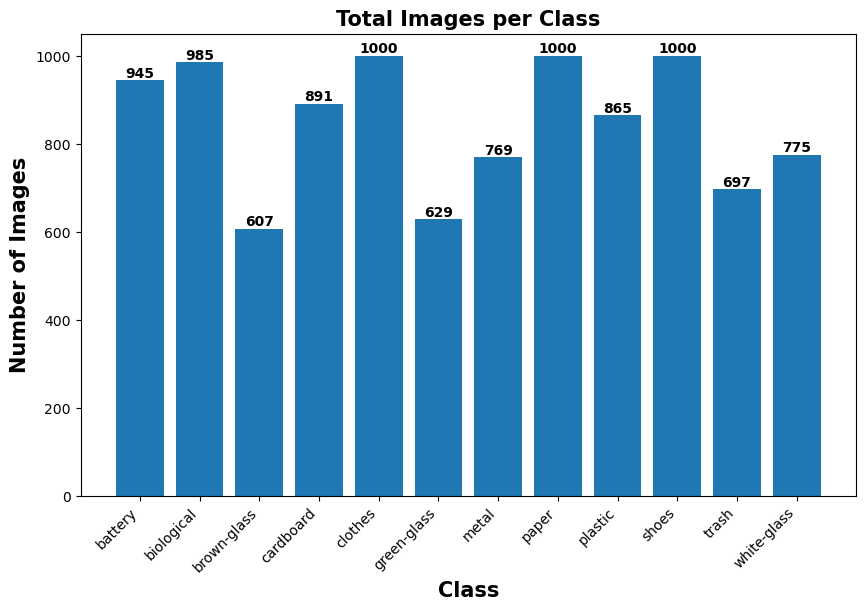

In [7]:
# Tạo danh sách rỗng để lưu tên lớp và số lượng hình ảnh
class_names = []
image_counts = []

# Lặp qua từng lớp
for c in classes:
    class_dir = os.path.join(IMAGE_PATH, c)
    image_files = list(Path(class_dir).glob("*.jpg"))
    
    # Thêm tên lớp và số lượng hình ảnh vào danh sách
    class_names.append(c)
    image_counts.append(len(image_files))

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(class_names, image_counts)
plt.xlabel('Class', fontweight='bold',size='15')
plt.ylabel('Number of Images', fontweight='bold',size='15')
plt.title('Total Images per Class', fontweight='bold',size='15')

# Hiển thị số lượng trên mỗi cột
for i, count in enumerate(image_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', rotation=0, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.show()

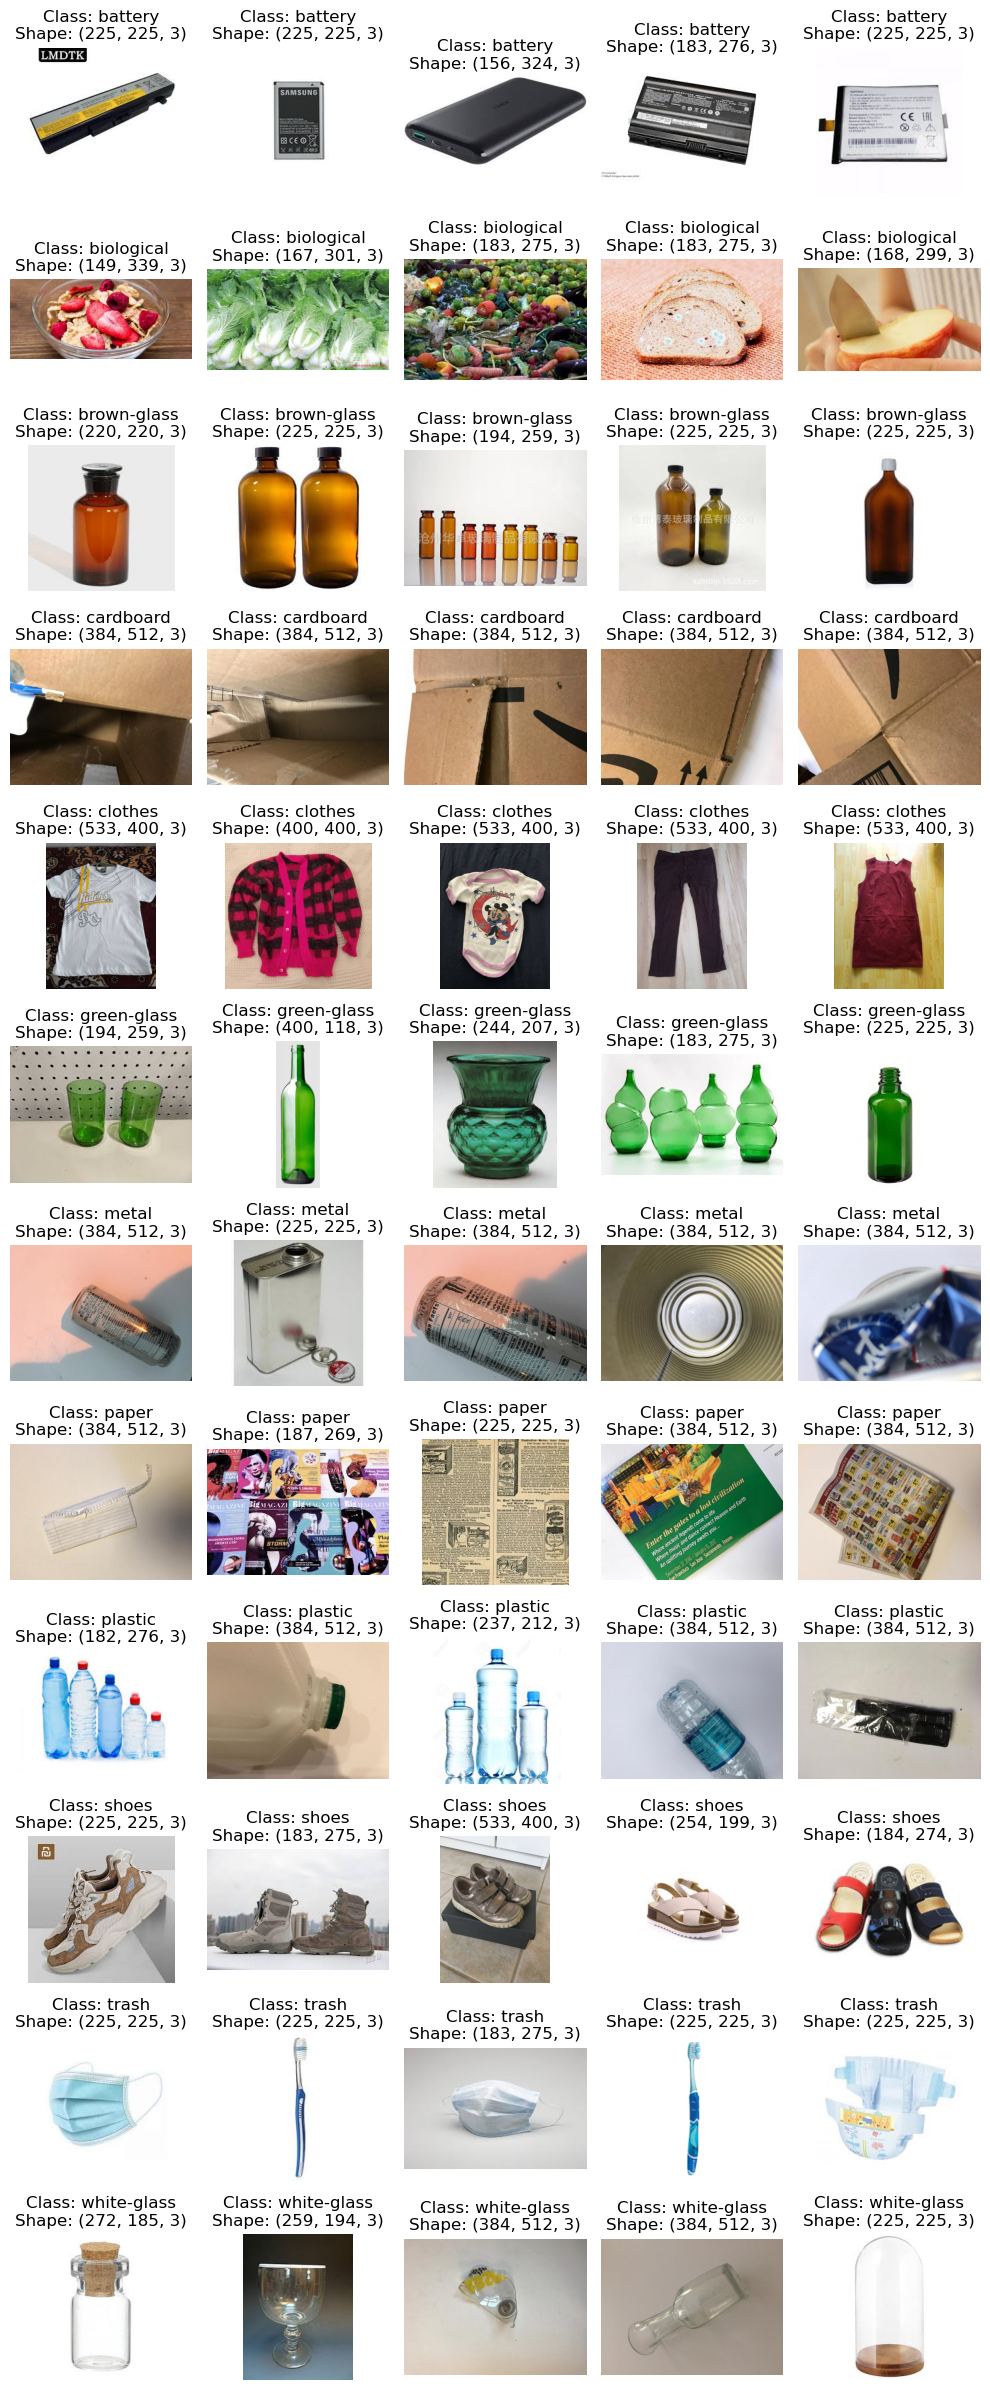

In [8]:
# Số lượng hình ảnh muốn hiển thị từ mỗi lớp
NUM_IMAGES = 5

fig, ax = plt.subplots(nrows = len(classes), 
                       ncols = NUM_IMAGES, 
                       figsize = (10, 24))

p = 0
# Lặp qua từng lớp
for c in classes:
    imgs_total = list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg"))
    
    # Chọn ngẫu nhiên một số hình ảnh từ mỗi lớp
    imgs_selected = random.choices(imgs_total, k = NUM_IMAGES)
    
    for i,img_select in enumerate(imgs_selected):
        img_bgr = cv2.imread(str(img_select))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}")
        ax[p,i].axis("off")
        
    p += 1
    
fig.tight_layout()
fig.show()

Tạo danh sách rỗng để lưu trữ đường dẫn và label của hình ảnh

In [9]:
# Tạo danh sách rỗng để lưu trữ đường dẫn và nhãn của hình ảnh
image_paths = []
labels = []
filenames = []

# Lặp qua từng lớp
for c in classes:
    class_dir = os.path.join(IMAGE_PATH, c)
    image_files = os.listdir(class_dir)
    
    # Lặp qua từng tệp hình ảnh trong thư mục lớp
    for image_file in image_files:
        # Lấy đường dẫn đầy đủ của hình ảnh
        image_path = os.path.join(class_dir, image_file)
        image_paths.append(image_path)
        labels.append(c)
        filenames.append(image_file)

# Tạo dataframe từ danh sách
data = pd.DataFrame({'image_path': image_paths, 'label': labels, 'filename': filenames})
data


,image_path,label,filename
0,D:\garbage_classification\battery\battery1.jpg,battery,battery1.jpg
1,D:\garbage_classification\battery\battery10.jpg,battery,battery10.jpg
2,D:\garbage_classification\battery\battery100.jpg,battery,battery100.jpg
3,D:\garbage_classification\battery\battery101.jpg,battery,battery101.jpg
4,D:\garbage_classification\battery\battery102.jpg,battery,battery102.jpg
...,...,...,...
10158,D:\garbage_classification\white-glass\white-gl...,white-glass,white-glass95.jpg
10159,D:\garbage_classification\white-glass\white-gl...,white-glass,white-glass96.jpg
10160,D:\garbage_classification\white-glass\white-gl...,white-glass,white-glass97.jpg
10161,D:\garbage_classification\white-glass\white-gl...,white-glass,white-glass98.jpg


# Model

In [10]:
# Shape of EfficientNetB0
im_shape = (180, 180)
batch_size = 32
SEED = 123

### Image Augmentation

**Image augmentation** là một kỹ thuật áp dụng các phép biến đổi khác nhau lên hình ảnh gốc, tạo ra nhiều bản sao đã được biến đổi của cùng một hình ảnh. Các kỹ thuật tăng cường hình ảnh này không chỉ mở rộng kích thước của tập dữ liệu mà còn mang lại mức độ đa dạng trong tập dữ liệu, giúp mô hình của bạn tổng quát hóa tốt hơn trên dữ liệu chưa từng thấy. Lớp **ImageDataGenerator** của Keras cung cấp một cách nhanh chóng và dễ dàng để tăng cường hình ảnh. Nó cung cấp nhiều kỹ thuật tăng cường khác nhau như chuẩn hóa, xoay, dịch chuyển, lật, thay đổi độ sáng và nhiều hơn nữa. Nó được thiết kế để cung cấp tăng cường dữ liệu theo thời gian thực, nghĩa là nó tạo ra các hình ảnh đã được tăng cường ngay lập tức trong khi mô hình của bạn vẫn đang trong giai đoạn huấn luyện. Lớp ImageDataGenerator đảm bảo rằng mô hình nhận được các biến thể mới của hình ảnh ở mỗi epoch.

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

In [12]:
path = [None] * len(IMAGE_PATH_LIST)
label = [None] * len(IMAGE_PATH_LIST)

for i,img_path in enumerate(IMAGE_PATH_LIST):
    path[i] = img_path
    label[i] = img_path.parent.stem
    
df_path_label = pd.DataFrame({"path":path, 
                              "label":label})

df_path_label.head()

df_train, df_valid = train_test_split(df_path_label, 
                                     test_size = 0.3, 
                                     random_state = SEED, 
                                     shuffle = True, 
                                     stratify = df_path_label["label"])

df_valid, df_test = train_test_split(df_valid, 
                                     test_size = 0.5, 
                                     random_state = SEED, 
                                     shuffle = True, 
                                     stratify = df_valid["label"])

#label_map = dict(zip(classes, range(0, len(classes))))

#df_train["label"] = df_train["label"].map(label_map)
#df_valid["label"] = df_valid["label"].map(label_map)
#df_test["label"] = df_test["label"].map(label_map)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

len(df_train), len(df_valid), len(df_test)

(7114, 1524, 1525)

In [13]:
Counter(df_train["label"])

Counter({'paper': 700,
         'green-glass': 440,
         'clothes': 700,
         'trash': 488,
         'biological': 689,
         'battery': 661,
         'metal': 538,
         'shoes': 700,
         'cardboard': 624,
         'brown-glass': 425,
         'plastic': 606,
         'white-glass': 543})

In [14]:
Counter(df_valid["label"])

Counter({'paper': 150,
         'clothes': 150,
         'battery': 142,
         'brown-glass': 91,
         'green-glass': 95,
         'white-glass': 116,
         'metal': 115,
         'trash': 105,
         'shoes': 150,
         'plastic': 129,
         'biological': 148,
         'cardboard': 133})

In [15]:
Counter(df_test["label"])

Counter({'green-glass': 94,
         'metal': 116,
         'battery': 142,
         'plastic': 130,
         'white-glass': 116,
         'cardboard': 134,
         'shoes': 150,
         'brown-glass': 91,
         'biological': 148,
         'clothes': 150,
         'paper': 150,
         'trash': 104})

Sử dụng ImageDataGenerator trên tập dữ liệu đào tạo, kiểm tra và xác thực.

In [16]:
df_train['path'] = df_train['path'].astype(str)
df_train['label'] = df_train['label'].astype(str)
train_generator = data_generator.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGE_PATH,
    x_col='path',
    y_col='label',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=SEED)

Found 7114 validated image filenames belonging to 12 classes.


In [17]:
df_valid['path'] = df_valid['path'].astype(str)
df_valid['label'] = df_valid['label'].astype(str)
valid_generator = data_generator.flow_from_dataframe(
    dataframe=df_valid,
    directory=IMAGE_PATH,
    x_col='path',
    y_col='label',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=SEED)

Found 1524 validated image filenames belonging to 12 classes.


In [18]:
df_test['path'] = df_test['path'].astype(str)
df_test['label'] = df_test['label'].astype(str)
test_generator = data_generator.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGE_PATH,
    x_col='path',
    y_col='label',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=SEED)

Found 1525 validated image filenames belonging to 12 classes.


In [19]:
nb_train_samples = train_generator.samples
nb_validation_samples = valid_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


### EfficientNetB0

**Transfer Learning** is a machine learning method where we reuse a pre-trained model as the starting point for a model on a new task. To put it simply—a model trained on one task is repurposed on a second, related task as an optimization that allows rapid progress when modeling the second task. By applying transfer learning to a new task, one can achieve significantly higher performance than training with only a small amount of data.

**EfficientNet-B0** is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 180-by-180.

In [20]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
'''
Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
We flatten the output of the convolutional layers to create a single long feature vector. 
And it is connected to the final classification model, which is called a fully-connected layer.
'''
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False

# model.summary()

optimizer = Adam()
'''
Optimizers are Classes or methods used to change the attributes of the model such as weights and learning rate 
in order to reduce the losses. Optimizers help to get results faster.
'''
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

epochs = 10

#Callback to save the best model
callbacks_list = [
    ModelCheckpoint(filepath='model_EfficientnetB0_10.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=valid_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/10


222/222 [==============================] - ETA: 0s - loss: 0.4092 - accuracy: 0.8688
Epoch 1: val_loss improved from inf to 0.24126, saving model to model_EfficientnetB0_10.h5
222/222 [==============================] - 100s 427ms/step - loss: 0.4092 - accuracy: 0.8688 - val_loss: 0.2413 - val_accuracy: 0.9295
Epoch 2/10
222/222 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9829
Epoch 2: val_loss did not improve from 0.24126
222/222 [==============================] - 92s 416ms/step - loss: 0.0523 - accuracy: 0.9829 - val_loss: 0.2790 - val_accuracy: 0.9315
Epoch 3/10
222/222 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9908
Epoch 3: val_loss did not improve from 0.24126
222/222 [==============================] - 94s 423ms/step - loss: 0.0267 - accuracy: 0.9908 - val_loss: 0.5000 - val_accuracy: 0.9049
Epoch 4/10
222/222 [==============================] - ETA: 0s - loss: 0.0307 - accuracy: 0.9897
Epoch 4: val_loss did not 

# Prediction and Accuracy

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
cm

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

1525/1525 [==============================] - 37s 23ms/step
Classification Report
              precision    recall  f1-score   support

     battery       0.96      0.97      0.97       142
  biological       0.96      0.97      0.97       148
 brown-glass       0.92      0.97      0.94        91
   cardboard       0.97      0.90      0.93       134
     clothes       0.99      0.97      0.98       150
 green-glass       0.92      0.91      0.92        94
       metal       0.93      0.89      0.91       116
       paper       0.89      0.93      0.91       150
     plastic       0.79      0.87      0.83       130
       shoes       0.97      0.98      0.97       150
       trash       0.93      0.95      0.94       104
 white-glass       0.89      0.78      0.83       116

    accuracy                           0.93      1525
   macro avg       0.93      0.92      0.92      1525
weighted avg       0.93      0.93      0.93      1525



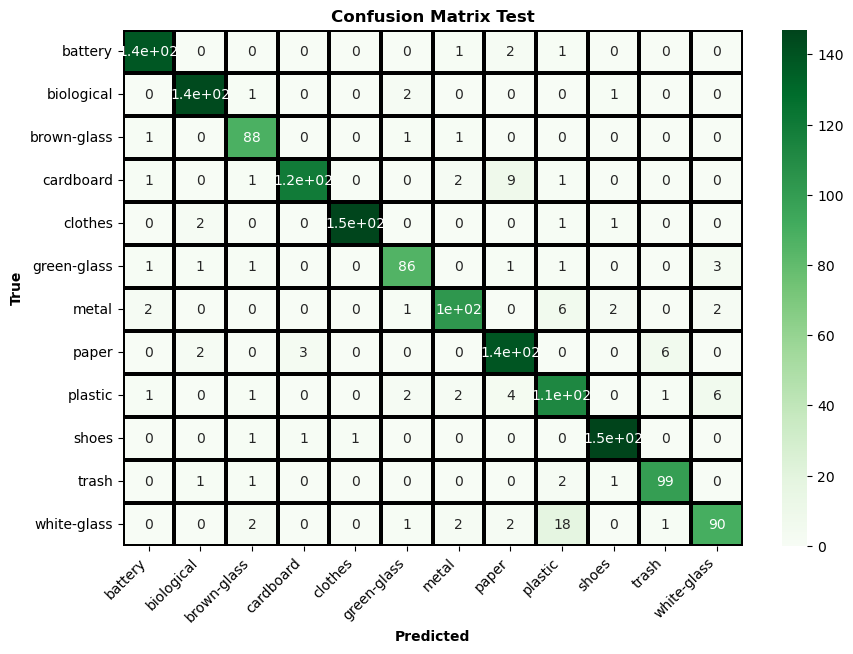

In [23]:
# We visualize the confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig,ax = plt.subplots(figsize=(10,6.7))
sns.heatmap(cm, 
            cmap = "Greens", 
            annot = True, 
            linewidths = 1.5,
            linecolor = "black",
            xticklabels = classes, 
            yticklabels = classes,
            ax = ax)

ax.set_title("Confusion Matrix Test", fontsize = 12, fontweight = "bold", color = "black")
ax.set_xlabel("Predicted", fontsize = 10, fontweight = "bold", color = "black")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("True", fontsize = 10, fontweight = "bold", color = "black")
fig.show()

- **Accuracy**

In [24]:
print(f"Accuracy: {accuracy_score(test_generator.classes, y_pred)}")

Accuracy: 0.9265573770491803


**Precision** is one indicator of a machine learning model's performance – the quality of a positive prediction made by the model. 
The **recall** is the measure of our model correctly identifying True Positives.
**F1 Score** is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. 


In [25]:
cm

array([[138,   0,   0,   0,   0,   0,   1,   2,   1,   0,   0,   0],
       [  0, 144,   1,   0,   0,   2,   0,   0,   0,   1,   0,   0],
       [  1,   0,  88,   0,   0,   1,   1,   0,   0,   0,   0,   0],
       [  1,   0,   1, 120,   0,   0,   2,   9,   1,   0,   0,   0],
       [  0,   2,   0,   0, 146,   0,   0,   0,   1,   1,   0,   0],
       [  1,   1,   1,   0,   0,  86,   0,   1,   1,   0,   0,   3],
       [  2,   0,   0,   0,   0,   1, 103,   0,   6,   2,   0,   2],
       [  0,   2,   0,   3,   0,   0,   0, 139,   0,   0,   6,   0],
       [  1,   0,   1,   0,   0,   2,   2,   4, 113,   0,   1,   6],
       [  0,   0,   1,   1,   1,   0,   0,   0,   0, 147,   0,   0],
       [  0,   1,   1,   0,   0,   0,   0,   0,   2,   1,  99,   0],
       [  0,   0,   2,   0,   0,   1,   2,   2,  18,   0,   1,  90]],
      dtype=int64)